# Time Series in Python

### Concept: White Noise
- A time-series where data doesn't follow a pattern.
- Typically, patterns identified in the past persist in the future.
- Since there are no patterns in white noise, it's unpredictable.

#### In order to consider a series aas white noise, it needs to satisfy the following conditions: 
1. Constant mean
2. Constant variance
3. No autocorrelation: Measures how correlated a series is with past versions of itself.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import yfinance
import warnings 
warnings.filterwarnings('ignore')
sns.set()

### Loading and Transforming Data

In [2]:
# raw_csv_data = pd.read_csv('inputs/Index2018.csv')
raw_csv_data = yfinance.download(tickers = '^GSPC ^FTSE ^N225 ^GDAXI', start = '1994-01-07', end = '2024-05-31', interval = '1d', group_by = 'ticker', auto_adjust = True, threads = True)
df_comp = raw_csv_data.copy()

# Add New Columns
df_comp['spx'] = df_comp['^GSPC'].Close
df_comp['ftse'] = df_comp['^FTSE'].Close
df_comp['nikkei'] = df_comp['^N225'].Close
df_comp['dax'] = df_comp['^GDAXI'].Close

#Remove first element since we always start 1 period before the first
df_comp = df_comp.iloc[1:] 
# Remove unnecessary columns
del df_comp['^GSPC']
del df_comp['^FTSE']
del df_comp['^N225']
del df_comp['^GDAXI']
# Set frequency of the data
df_comp = df_comp.asfreq('b')
# Fill missing values
df_comp = df_comp.ffill()

df_comp.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,spx,ftse,nikkei,dax
Price,,,,
Date,,,,
1994-01-10,475.269989,3440.600098,18443.439453,2225.000000
1994-01-11,474.130005,3413.800049,18485.250000,2228.100098
1994-01-12,474.170013,3372.000000,18793.880859,2182.060059
1994-01-13,472.470001,3360.000000,18577.259766,2142.370117
1994-01-14,474.910004,3400.600098,18973.699219,2151.050049


### Remove Unecessary Data

In [3]:
df_comp['market_value'] = df_comp.spx
del df_comp['spx'], df_comp['dax'], df_comp['ftse'], df_comp['nikkei']

### Split Dataset

In [4]:
size = int(len(df_comp)*0.8)
df_train, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
df_train.head()

Ticker,market_value
Price,
Date,
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013
1994-01-13,472.470001
1994-01-14,474.910004


### White Noise

In [5]:
wn = np.random.normal(loc = df_train.market_value.mean(), scale = df_train.market_value.std(), size = len(df_train))
df_train['wn'] = wn
df_train.describe()

Ticker,market_value,wn
Price,,
count,6343.000000,6343.000000
mean,1303.567928,1304.612494
std,505.940120,504.926240
min,438.920013,-567.856519
25%,996.819977,957.727381
50%,1238.250000,1299.314306
75%,1471.484985,1640.764960
max,2872.870117,3184.161542


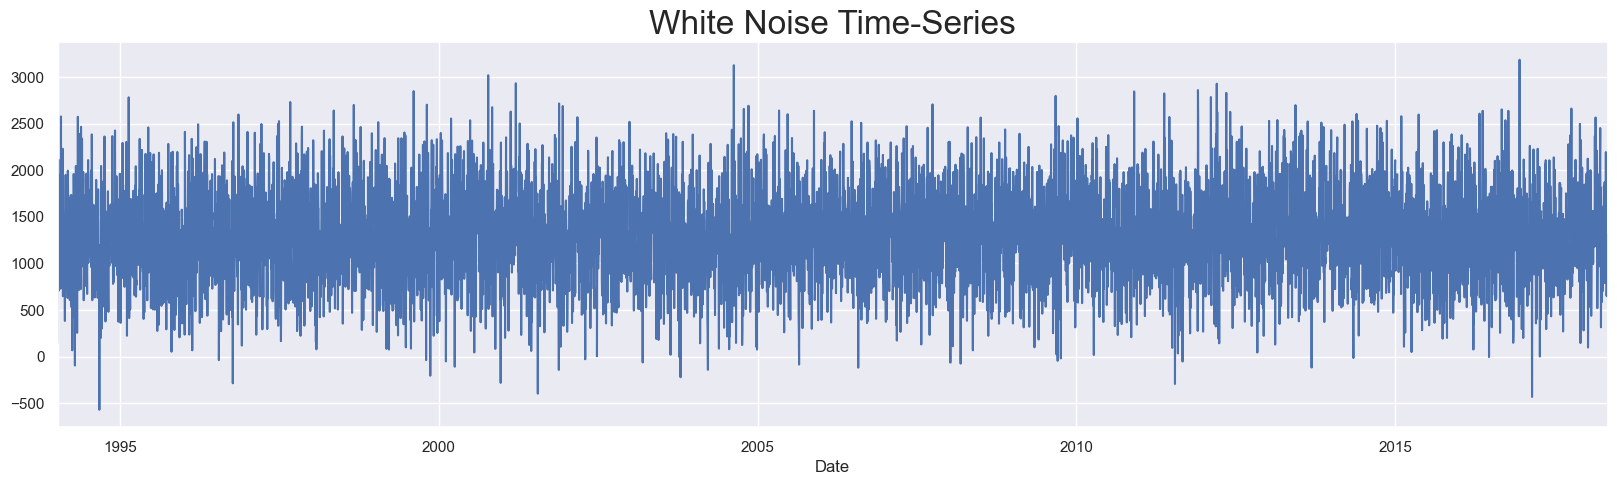

In [6]:
# Plot the white noise
df_train.wn.plot(figsize = (20,5))
plt.title('White Noise Time-Series', size=24)
plt.show()

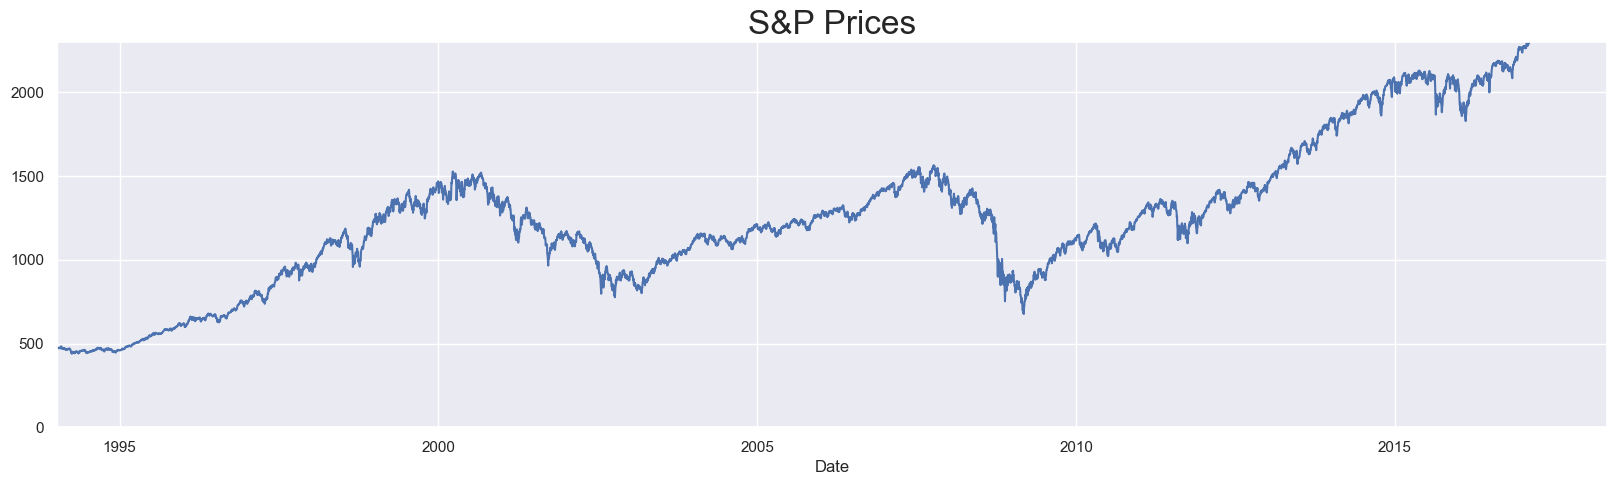

In [7]:
# Plot S&P prices
df_train.market_value.plot(figsize = (20,5))
plt.title('S&P Prices', size=24)
plt.ylim(0,2300)
plt.show()

### Concept: Random Walk
- A special type of time series, where patterns persist over time and the differences between periods are simply white noise.


In [8]:
# Import random walk dataset
rw_df = pd.read_csv('inputs/RandWalk.csv')
rw_df.date = pd.to_datetime(rw_df.date, dayfirst = True)
rw_df.set_index('date', inplace = True)
rw_df.asfreq('b')
rw_df.head()

,price
date,
1994-01-07,1122.139662
1994-01-08,1135.238562
1994-01-09,1109.897831
1994-01-10,1080.347860
1994-01-11,1082.095245


In [9]:
rw_df.describe()

,price
count,7029.000000
mean,1269.648367
std,443.999180
min,574.382397
25%,931.488599
50%,1155.773451
75%,1488.957260
max,2715.508720


In [10]:
df_train['rw'] = rw_df.price
df_train.rw.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
df_train.tail()

Ticker,market_value,wn,rw
Price,,,
Date,,,
2018-04-26,2666.939941,653.903067,NaN
2018-04-27,2669.909912,767.164614,NaN
2018-04-30,2648.050049,1316.231834,NaN
2018-05-01,2654.800049,918.409198,NaN
2018-05-02,2635.669922,644.550068,NaN


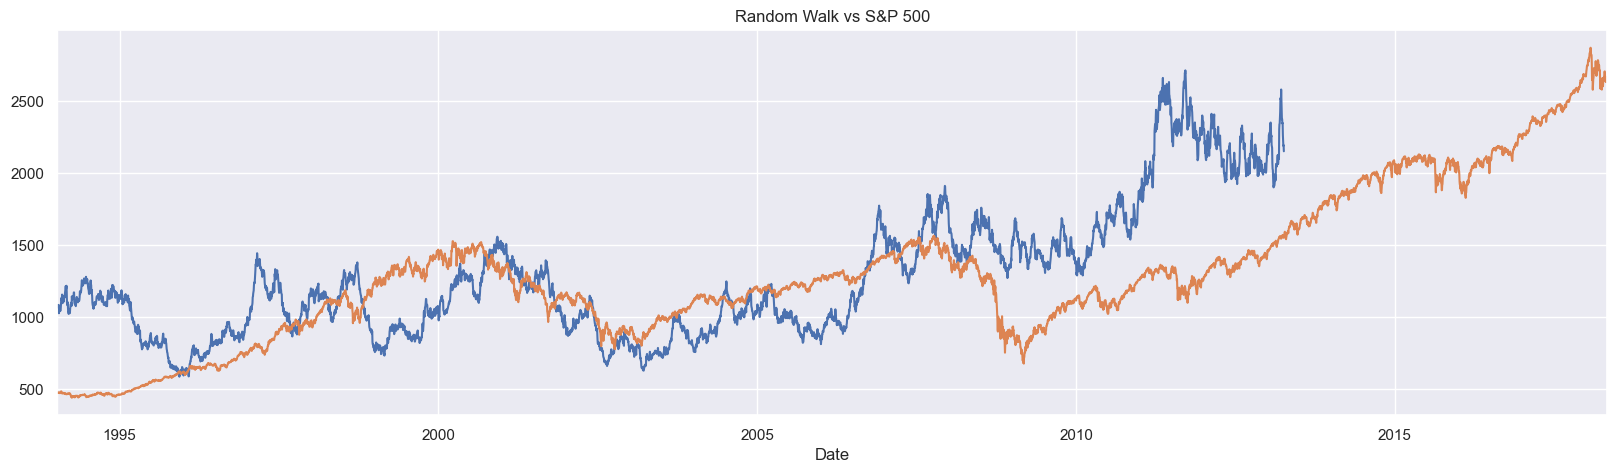

In [11]:
# Plot the random walk
df_train.rw.plot(figsize = (20,5))
df_train.market_value.plot(figsize = (20,5))
plt.title('Random Walk vs S&P 500')
plt.show()

### Insights:
- Both plots have small variations between consecutive time periods.
- Cyclical increases and decreases in short periods of time.

### Concept: Market Efficiency
- Measures the level of diffuclty in forecasting correct future values.
- Generally, if a time series resembles a random walk, the future values (prices) cannot be predicted with great accuracy.
- If prices can be predicted with great accuracy, then there are arbitrage opportunities.
- Arbitrage is when an investor buys and sells commodities and makes a safe profit, while the price adjusts.

## Stationarity

### Concept: Weak Form/Covariance Stationarity
- Consecutive samples of data taken at intervals with the same size should have identical covariances, regardless of the the starting point.
- Covariance is correlation multiplied by standard deviation.
- Example: White Noise - Autocorrelation between lags is always zero.

### Covariance Stationarity Assumptions:
- Constant Mean
- Constant Standard Deviation
- Consistent Covariance at identical distances.

### Concept: Strict Stationarity
- Samples of identical size have identical distributions.
- Rarely observed in nature.
- Industry standard -  Stationarity is used to describe covariance stationarity.

### Technique: Dickey-Fuller Test
- Check whether a dataset comes from a stationary process.
- Null Hypothesis ($ H_{0} $): Non-stationarity. One lag autocorrelation coefficient is less than one.
- Alternate Hypothesis ($ H_{1} $): One lag autocorrelation coefficient is one.
- Reject $ H_{0} $ if test statistic < critical value.

In [12]:
sts.adfuller(df_train.market_value)

(0.32059581396968123,
 0.9782699268544018,
 9,
 6333,
 {'1%': -3.4313829942430267,
  '5%': -2.861996492903811,
  '10%': -2.5670129880861614},
 51143.59251665408)

#### Output Evaluation
- Line 1: Test Statistic. This is greater than all three Confidence Inervals (CIs). Fail to reject the null hypothesis.
- Line 2: P-value associated with the test statistic. Percentage chance of not rejecting the null. Makes sense why we have the above outcome. We cannot confirm that the data is stationary.
- Line 3: The number if lags used in the regression when determining the test statistic. This value implies that there is some autocorrelation going back 9 periods. Take this into account when picking the appropriate model.
- Line 4: Number of observations used in the analysis. Depends on the number of lags used in the regression. The sum of these should equal the size of the dataset.
- Line 5: Critical Values at 99%, 95% and 90% CIs.
- Line 6: Estimate of the maximised information criteria provided there is some apparent autocorrelation. The lower the value, the easier it is to make predictions of the future.

In [13]:
# Run a comparative test using White Noise (Because we know that WN is a stationary process, we expect a low p-value.)
sts.adfuller(df_train.wn) # No lags due to no autocorrelation.

(-55.33997847639326,
 0.0,
 1,
 6341,
 {'1%': -3.4313816904576666,
  '5%': -2.8619959168449522,
  '10%': -2.567012681436692},
 96427.92898032199)

In [14]:
# Run a comparative test on random walk data. (Because we expect RW to be a non-stationary process, we expect a high p-value)
sts.adfuller(df_train.rw.fillna(0)) 

(-1.8027311286105565,
 0.37910660959157705,
 20,
 6322,
 {'1%': -3.431384792337843,
  '5%': -2.861997287365799,
  '10%': -2.5670134109967444},
 62780.56113863383)

# Seasonality

### Concept: Seasonality Certain trends will appear on a cyclical basis.

#### Ways to test for Seasonality
- Decomposition (Decompose the sequence): Split time-series into 3 effects (trend: pattern, seasonal: cyclical effects and residual: error of prediction).
- Naive Decomposition: We expect a linear relationship between the 3 parts and the observed time-series. (additive: observed sum of trend, seasonal and residual values; multiplicative: observed product of trend, seasonal and cyclical values)

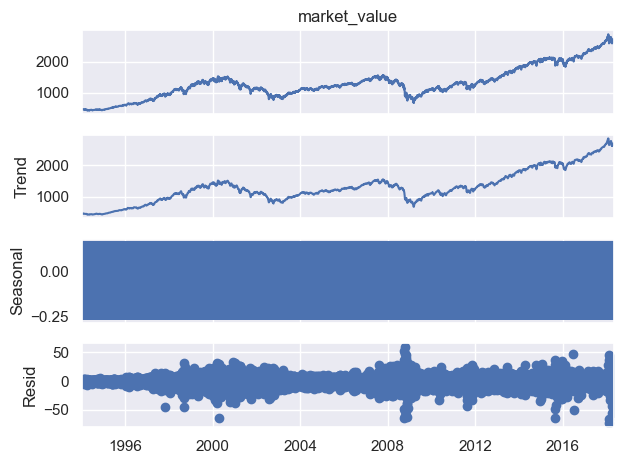

In [15]:
s_dec_additive = seasonal_decompose(df_train.market_value, model = 'additive')
s_dec_additive.plot()
plt.show()

#### Output Evaluation:
- No seasonality.
- Trend based on observed data.
- Residuals vary greatly around 2000 (dot com bubble), 2008 (housing crisis bubble) and 2016.

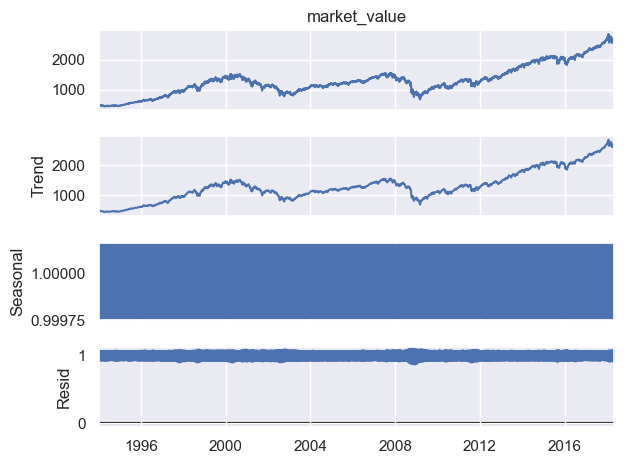

In [16]:
s_dec_multiplicative = seasonal_decompose(df_train.market_value, model = 'multiplicative')
s_dec_multiplicative.plot()
plt.show() # Further proof that there is no seasonality among market_values

### Concept: Correlation
- Measures the similarity in the change of values in two series.

### Concept: Autocorrelation
- Measures the correlation between a sequence and itself.
- Measures the level of resemblance between a sequence from previous periods (lag) and observed values.

## Autocorrelation Function (ACF)
- Computes the autocorrelation value for the number of lags we specify simlutaneously.
- Includes indirect relationships (impact of several lags of observations).

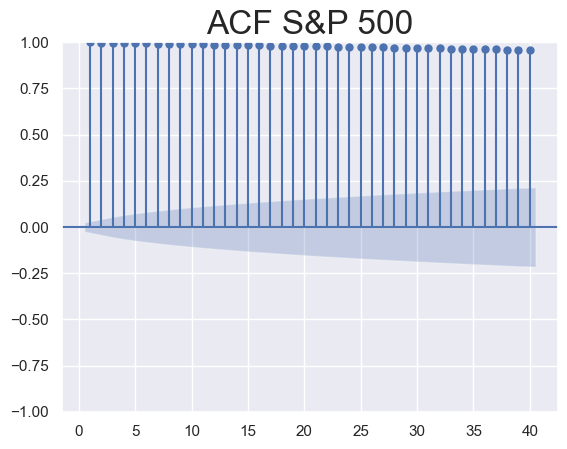

In [17]:
sgt.plot_acf(df_train.market_value, lags = 40, zero = False) # common practice is to use 40 lags (last 40 periods).
plt.title('ACF S&P 500', size = 24)
plt.show()

### Output Evaluation:
- High autocorrelation coefficients indicate high significance.
- Light blue shaded area indicates that older values are less signifigant than recent values.
- Coeffecient vaalues only change slightly over time. This suggests that older prices (a month back) can still serve as decent estimators.

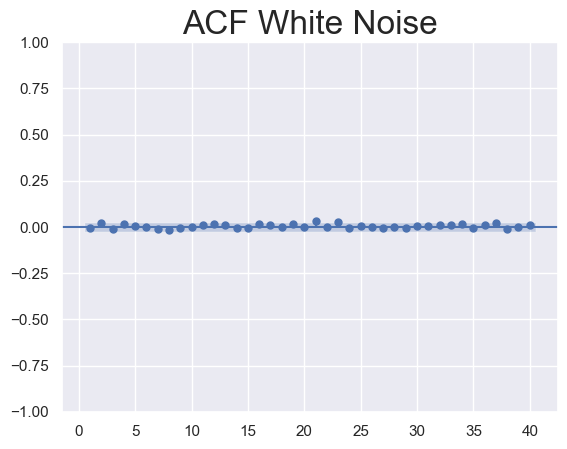

In [18]:
# Plot the ACF of White Noise for comparison
sgt.plot_acf(df_train.wn, lags = 40, zero = False) # common practice is to use 40 lags (last 40 periods).
plt.title('ACF White Noise', size = 24)
plt.show()

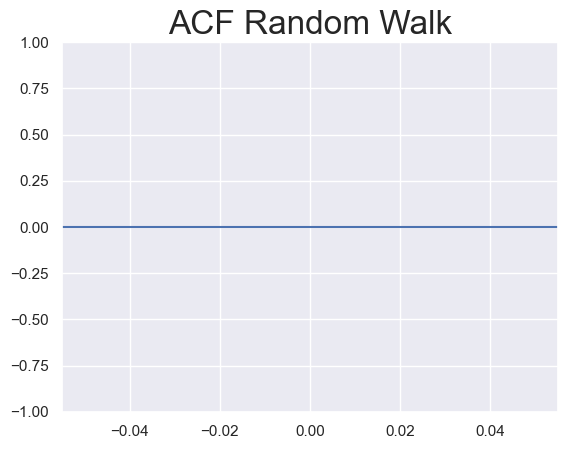

In [19]:
# Plot the ACF of Random Walk for comparison
sgt.plot_acf(df_train.rw, lags = 40, zero = False) # common practice is to use 40 lags (last 40 periods).
plt.title('ACF Random Walk', size = 24)
plt.show()

## Partial Autocorrelation Function (PACF)
- Includes direct relationship (impact of single lag of observations).

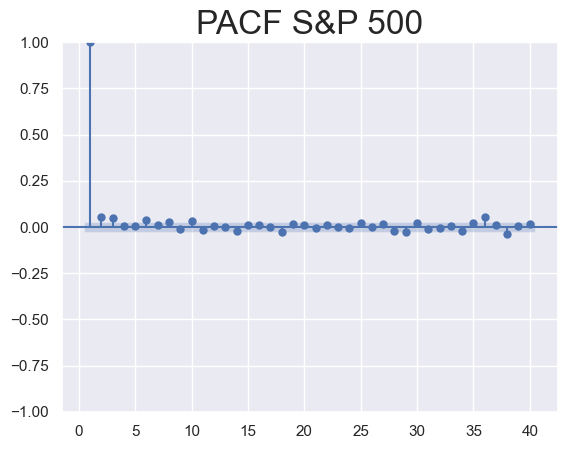

In [20]:
sgt.plot_pacf(df_train.market_value, lags = 40, zero = False, method = ('OLS')) # common practice is to use 40 lags (last 40 periods).
plt.title('PACF S&P 500', size = 24)
plt.show()

### Output Evaluation:
- First value is the same as the ACF.
- Values aafter the third are in the blue shaded area (have less significance).

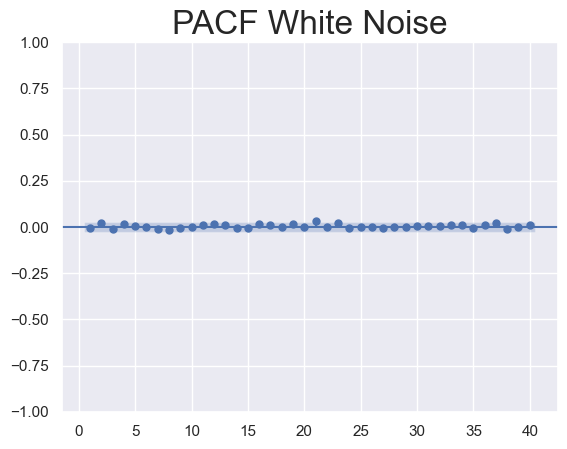

In [21]:
# Plot the PACF of White Noise for comparison
sgt.plot_pacf(df_train.wn, lags = 40, zero = False, method = ('OLS')) # common practice is to use 40 lags (last 40 periods).
plt.title('PACF White Noise', size = 24)
plt.show()

In [22]:
# Plot the PACF of Random Walk for comparison
# sgt.plot_pacf(df_train.rw, lags = 40, zero = False, method = ('OLS')) # common practice is to use 40 lags (last 40 periods).
# plt.title('PACF Random Walk', size = 24)
# plt.show()

### Picking the Model
1. Select only significant coefficients: High predictive value. Low test-statistic and low p-value.
2. Parsimonious (as simple as possible): Prefer simpler model over complex model unless the complex model provides signifcantly better predictions. This is determined by the log likelihood ratio (LLR) test (Can only be applied to models with different degrees of freedom).
3. Residuals should resemble white noise: This helps us conclude that there is no other pattern we can account for (or have missed) without overtraining the model.

### Technique Log Likelihood Ratio (LLR): 
- Same total number of lags means no LLR.
- The higher the LLR and the lower the coefficient, the fewer observations (less data) are required for accurate predictions.
- Information Criteria: Opt for the model with lower AIC and BIC coefficients.